<a href="https://colab.research.google.com/github/soumendra375/DEEP-LEARNING/blob/master/Intro_To_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTRODUCTION TO REGULARIZATION FOR DEEP NEURAL NETS

DEMONSTRATION OF OVER-PARAMETERIZATION

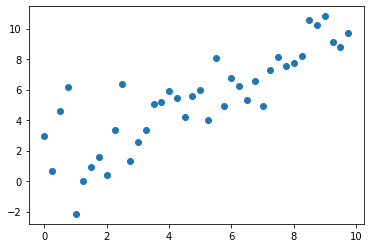

In [31]:
%matplotlib inline
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from numpy.random import normal, seed
import sklearn.linear_model as slm
from sklearn.preprocessing import scale
import sklearn.model_selection as ms
from math import sqrt
import keras
import keras.models as models
import keras.layers as layers
from keras.layers import Dropout, LeakyReLU
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from tensorflow import set_random_seed

seed(34567)
x = np.arange(start = 0.0, stop = 10.0, step = 0.25)
y = np.add(x, normal(scale = 2.0, size = x.shape[0]))

plt.scatter(x,y)

Notice that these data points fall approximately on a straight line, but with significant deviations.
Next, we will compute a simple regression model. This model has an intercept term and a single slope parameter. The code in the cell below splits the data into randomly selected training and testing subsets. Executing the below code.

In [0]:
indx = range(len(x))
seed(9988)
indx = ms.train_test_split(indx, test_size = 20)
x_train = np.ravel(x[indx[0]])
y_train = np.ravel(y[indx[0]])
x_test = np.ravel(x[indx[1]])
y_test = np.ravel(y[indx[1]])

Next, we will use the linear model in sklearn.linear_model package to create a single regression model for these data. The code in the cell below does just this, prints the single model coefficient, and plots the result. Executing the above code.

[2.18028763]


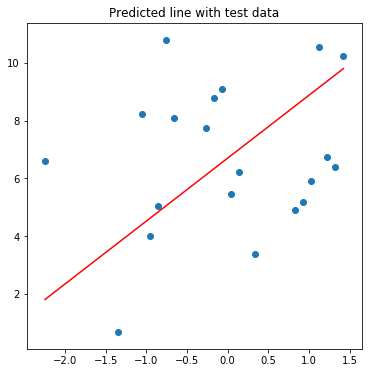

In [4]:
def plot_reg(x, y_score, y):
  ax = plt.figure(figsize=(6, 6)).gca() # define axis

  ## Get the data in plot order
  xy = sorted(zip(x,y_score))
  x = [x for x, _ in xy]
  y_score = [y for _, y in xy]

  ## Plot the result
  plt.plot(x, y_score, c = 'red')
  plt.scatter(x, y)
  plt.title('Predicted line with test data')

def reg_model(x, y):
  mod = slm.LinearRegression()
  x_scale = scale(x) # .reshape(-1, 1)
  mod.fit(x_scale, y)
  print(mod.coef_)
  return mod, x_scale, mod.predict(x_scale)

mod, x_scale, y_hat = reg_model(x_train.reshape(-1,1), y_train)

plot_reg(x_scale, y_hat, y_train)

Examine these results. Notice that the single coefficient (slope) seems reasonable, given the standardization of the training data. Visually, the fit to the training data also looks reasonable. 

We should also test the fit to some test data. The code in the cell does just this and returns the RMS error. execute this code.

1.9292639905624638

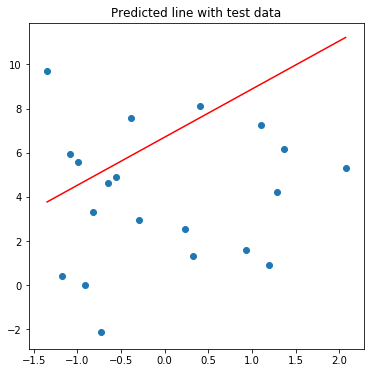

In [5]:
from math import sqrt
def test_mod(x,y, mod):
  x_scale = scale(x)
  y_score = mod.predict(x_scale)
  plot_reg(x_scale, y_score, y)
  return np.std(y_score - y)

test_mod(x_test.reshape(-1,1), y_test, mod)

Again, these results look reasonable. The RMSE is relatively small given the significant dispersion in these data.
Now, try a model with significantly higher capacity. In this case we compute new features for a 9th order polynomial model. Using this new set of features a regression model is trained and a summary displayed.

[    3801.79377166   -55910.91606885   340393.61250374 -1135034.00411226
  2291726.98006709 -2884767.48287056  2217807.98188647  -954167.45883997
   176179.90381577]
0.73296816947701


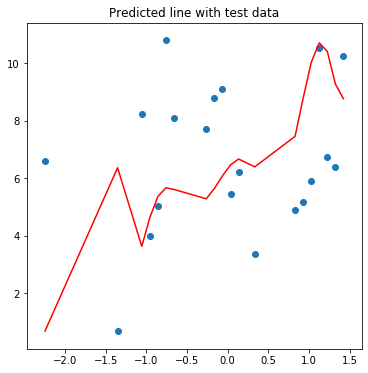

In [6]:
seed(2233)
x_power = np.power(x_train.reshape(-1,1), range(1,10))
x_scale = scale(x_power)
mod_power = slm.LinearRegression()
mod_power.fit(x_scale, y_train)
y_hat_power = mod_power.predict(x_scale)

plot_reg(x_scale[:,0], y_hat_power, y_train)

print(mod_power.coef_)
print(np.std(y_hat_power - y_train))

Notice the following, indicating the model is quite over-fit. 
- There is a wide range of coefficient values across 7 orders of magnitude. This situation is in contrast to the coefficient of the single regression model which had a reasonable single digit value.
- The graph of the fitted model shows highly complex behavior. In reality, this behavior indicates the model is 'learning the data'.  

Now, we will try to test the model with the held-back test data. The code in the cell below creates the same features and applies the `predict` method to the model using these test features. 

1005937.9132281716


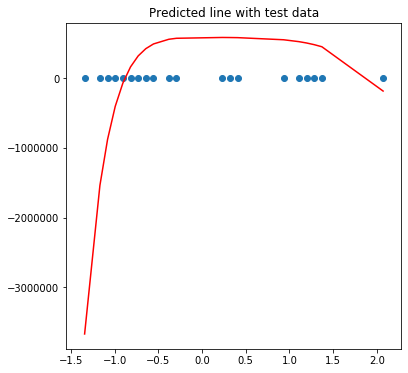

In [7]:
x_test_scale = scale(x_test.reshape(-1,1)) # Prescale to prevent numerical overflow.
x_test_power = np.power(x_test_scale, range(1,10))
x_scale_test = scale(x_test_power)

y_hat_power = mod_power.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_power, y_test)
print(np.std(y_hat_power - y_test))

This is clearly a terrible fit! The RMSE is enormous and the curve of predicted values bears little resemblance to the test values. Indeed, this is a common problem with over-fit models that the errors grow in very rapidly toward the edges of the training data domain. We can definitely state that this model **does not generalize**. 

**l2 regularization**

**REGULARIZATION FOR REGRESSION**

1.6411533913788632
[0.20408965 0.17704734 0.16126008 0.14938273 0.13910696 0.12970734
 0.12089205 0.11252201 0.10452947]


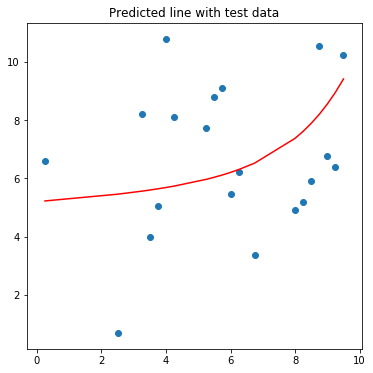

In [8]:
mod_L2 = slm.Ridge(alpha = 100.0)
mod_L2.fit(x_scale, y_train)
y_hat_L2 = mod_L2.predict(x_scale)

print(np.std(y_hat_L2 - y_train))
print(mod_L2.coef_)

plot_reg(x_train, y_hat_L2, y_train)

This model is quite different from the un-regularized one we trained previously. 
- The coefficients all have small values. Some of the coefficients are significantly less than 1. These small coefficients are a direct result of the l2 penalty.
- The fitted curve looks rather reasonable given the noisy data.

Now test the model on the test data. Execute the code in the cell below and examine the results. 

2.4507444626408863


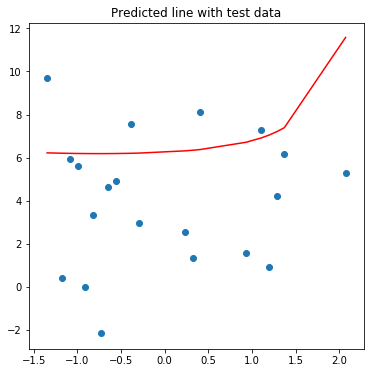

In [9]:
y_hat_L2 = mod_L2.predict(x_scale_test)
plot_reg(x_scale_test[:,0], y_hat_L2, y_test)
print(np.std(y_hat_L2 - y_test))

This result looks a lot more reasonable. The RMSE is nearly the same as for the single feature regression example. Also, the predicted curve looks reasonable.
In summary, we have seen that l2 regularization significantly improves the result for the 9th order polynomial regression. The coefficients are kept with in a resonable range and the predictions are much more reasonable than the unconstrained model.

l2 regularization for Deep learning models
So, you may well wonder, how l2 regularization applies to neural networks? Let's give it a try using the 9th order polynomial data.
The code in the cell below defines and fits the regression model with a single hidden layer with 128 units. No regularization is applied in this first model.

**l2 regularization for deep learning models**

The code in the cell below defines and fits the regression model with a single hidden layer with 128 units. No regularization is applied in this first model.

In [10]:
nr.seed(345)
set_random_seed(4455)
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                 epochs = 30, batch_size = 1,
                 validation_data = (x_scale_test, y_test),
                 verbose=0)

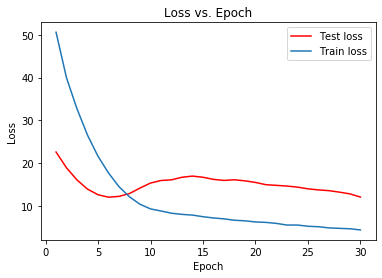

In [11]:
def plot_loss(history):
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']
  x = list(range(1, len(test_loss) + 1))
  plt.plot(x, test_loss, color = 'red', label = 'Test loss')
  plt.plot(x, train_loss, label = 'Train loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs. Epoch')

plot_loss(history)

It looks like this model becomes overfit after 3 or 4 training epochs
Execute the code in the cell below to compute and plot predictions for the unconstrained model.

5.29855480237221


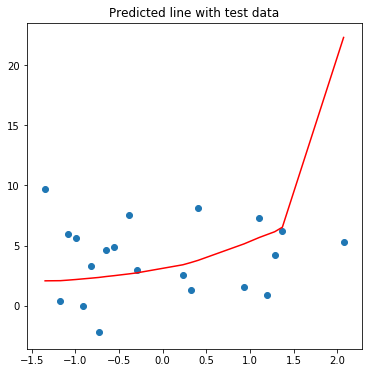

In [12]:
history = nn.fit(x_scale, y_train,
                 epochs = 4, batch_size = 1,
                 validation_data = (x_scale_test, y_test),
                 verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:, 0], predicted, y_test)
print(np.std(predicted - y_test))

Both the high RMSE and the odd behavior of the predicted curve indicates that this model does not generalize well at all. Notice in particular, how the predicted curve moves away from the test data values on the right. 

Now, we will try to improve this result by applying l2 norm regularization to the neural network. The code in cell below adds l2 regularization to the model. Execute the code and examine the results.

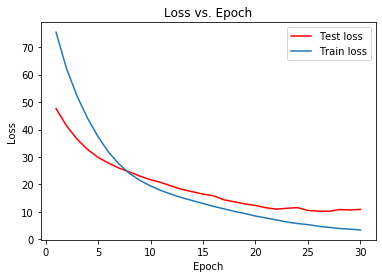

In [13]:
nr.seed(45678)
set_random_seed(45546)
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                    kernel_regularizer=regularizers.l2(2.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train,
                 epochs = 30, batch_size = 1,
                 validation_data = (x_scale_test, y_test),
                 verbose = 0)
plot_loss(history)

This loss function is quite a bit different than for the unconstrained model. It is clear that regularization allows many more training epochs before over-fitting. 

But are the predictions any better? Execute the code in the cell below and find out. 

3.665324744814742


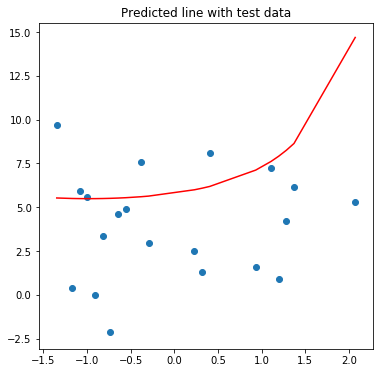

In [14]:
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

The l2 regularization has reduced the RMSE. Just as significantly, the pathological behavior of the predicted values on the right is reduced, but clearly not eliminated. The bias effect is also visible. Notice that the left part of the fitted curve is now shifted upwards.

EXERCISE 1: You now tried l2 regularization with one choice of regularization hyperparameter, namely the regularization parameter. Finding a good choice for the regularization parameter can require some trial and error. The objective is to find a value that produces a minimum test error.
In the code cells below, create models as follows:
1. A regularization parameter of 20.0, using a numpy.random.seed of 9456 and set_random_seed for the TensorFlow backend of 55566.
2.A regularization parameter of 200.0, using a numpy.random.seed of 9566 and set_random_seed for the TensorFlow backened of 44223.

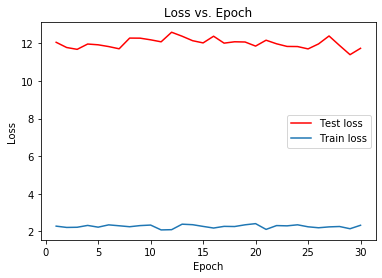

In [15]:
nr.seed(9456)
set_random_seed(55566)
nn20 = models.Sequential()
nn20.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                    kernel_regularizer=regularizers.l2(2.0)))
nn20.add(layers.Dense(1))
nn20.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history20 = nn.fit(x_scale, y_train, 
                 epochs = 30, batch_size = 1,
                 validation_data = (x_scale_test, y_test),
                 verbose=0)
plot_loss(history20)

3.6397550930541502


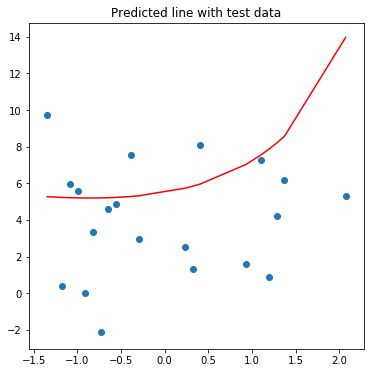

In [16]:
history20 = nn20.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted20 = nn20.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted20, y_test)
print(np.std(predicted20 - y_test))

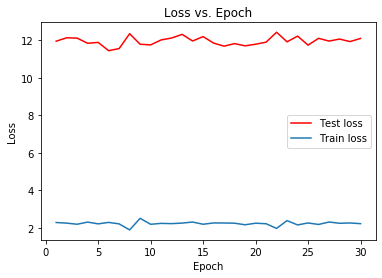

In [17]:
nr.seed(9566)
set_random_seed(44223)
nn200 = models.Sequential()
nn200.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                    kernel_regularizer=regularizers.l2(2.0)))
nn200.add(layers.Dense(1))
nn200.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history200 = nn.fit(x_scale, y_train, 
                 epochs = 30, batch_size = 1,
                 validation_data = (x_scale_test, y_test),
                 verbose=0)
plot_loss(history200)

3.8106294592288443


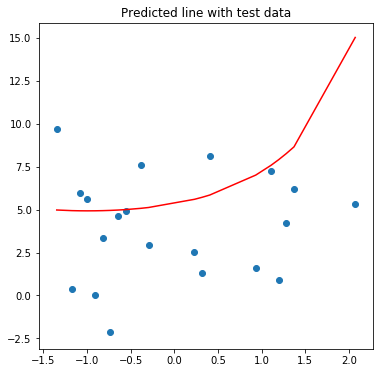

In [18]:
history200 = nn200.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted200 = nn200.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted200, y_test)
print(np.std(predicted200 - y_test))

**L1 REGULARIZATION**
With these ideas in mind, let's apply l1 norm regularization to the 9th order polynomial regression problem. The code in cell below applies l1 regularized or Lasso regularization to the linear regression problem. Execute this code and examine the results.

2.9447844435467823
[0.18028763 0.         0.         0.         0.         0.
 0.         0.         0.        ]


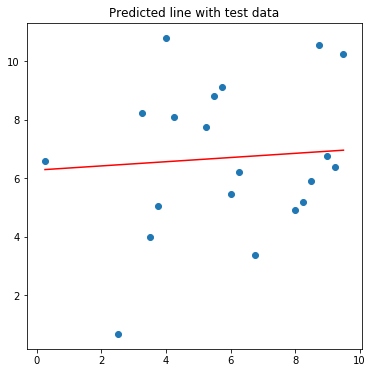

In [19]:
mod_L1 = slm.Lasso(alpha = 2.0, max_iter=100000)
mod_L1.fit(x_scale, y_train)
y_hat_L1 = mod_L1.predict(x_scale)

print(np.std(y_hat_L1 - y_test))
print(mod_L1.coef_)

plot_reg(x_train, y_hat_L1, y_train)

Notice the following about the results of this L1 regularized regression:

1. Many of the coefficients are 0, as expected.
2. The fitted curve looks reasonable.

2.8637221190877193


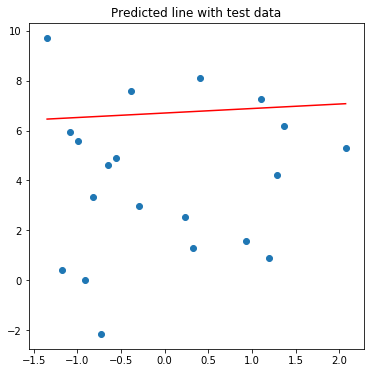

In [20]:
y_hat_L1 = mod_L1.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L1, y_test)

print(np.std(y_hat_L1 - y_test))

The RMSE has been reduced considerably, and is less than for l2 regularization. The plot of predicted values looks similar to the

**NEURAL NETWORK WITH l1 REGULARIZATION**

Now, we will try l1 regularization with a neural network. The code in the cell below defines, fits and plots a single layer neural network using l1 regularization.
Executing the code under and examining the results

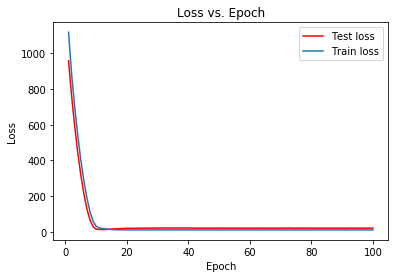

In [21]:
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                    kernel_regularizer=regularizers.l1(10.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train,
                 epochs = 100, batch_size = 1,
                 validation_data = (x_scale_test, y_test),
                 verbose = 0)
plot_loss(history)

These results are a defined improvement. The RMSE is similar to that produced by the l2 regularization neural network. Further the fitting curve shows similar behavior and bias. This bias is the result of the regularization.

**EARLY STOPPING EXAMPLES**

Manually applying early stopping is both computationally inefficient and rather tedious. Fortunately, Keras has a build in capability that allows automation.

To implement this early stopping we need to define 2 Keras callbacks. Two such callbacks are required:

The first callback, EarlyStopping, is for the early stopping method.
The second call back checkpoints or saves the current model.
These callbacks are defined in the form of a callbacks list.

Notice that the model defined includes l2 regularization. Thus, this model should replicate the performance observed with manual early stopping. To see how this works, examine and then execute the code in the following cell.

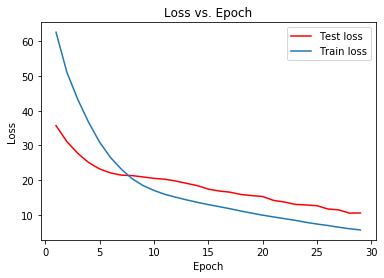

In [22]:
## First define and compile a model. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(1.0)))
nn.add(layers.Dense(1))

nn.compile(optimizer = 'RMSprop', loss = 'mse', metrics = ['mae'])

## Define the callback list
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 1 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now fit the model
nr.seed(5566)
set_random_seed(6767)
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

You can see the behavior of the loss with training epoch is behaving as with l2 regularization alone. Notice that the training has been automatically terminated at the point the loss function is at its optimum.

Let's also have a look at the accuracy vs. epoch. Execute the code in the cell below and examine the result.

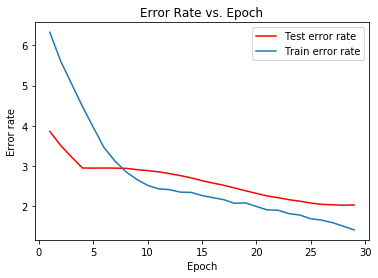

In [23]:
def plot_accuracy(history):
    train_acc = history.history['mean_absolute_error']
    test_acc = history.history['val_mean_absolute_error']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test error rate')
    plt.plot(x, train_acc, label = 'Train error rate')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error rate')
    plt.title('Error Rate vs. Epoch')  
    
plot_accuracy(history)  

The curve of test accuracy is consistent with the test loss.

The code in the cell below retrieves the best model (by our stopping criteria) from storage, computes predictions and displays the result. Execute this code and examine the results.

4.306624992661737


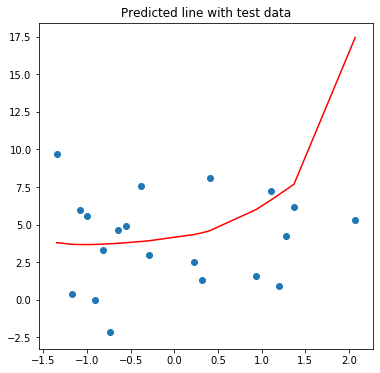

In [24]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

As expected, these results are similar, but a bit worse, than those obtained while manually stopping the training of the l2 regularized neural network.

**Computing a neural network with dropout regularization**


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


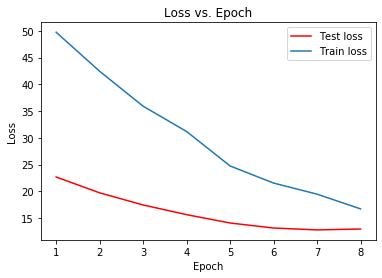

In [25]:
## First define and compile a model with a dropout layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(Dropout(rate = 0.5)) # Use 50% dropout on this model
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

## Now fit the model
nr.seed(1144)
set_random_seed(6723)
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

The familiar loss plot looks a bit different here. Notice the kinks in the training loss curve. This is likely a result of the dropout sampling.

Execute the code in the cell below, and examine the accuracy vs. epoch curves.

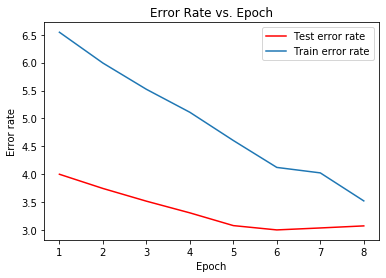

In [26]:
plot_accuracy(history)

The behavior of the training accuracy curve has a similar appearance to the loss curve in terms of the jagged appearance.

Execute the code in the cell below examine the prediction results for this model.

**Batch Normalization**

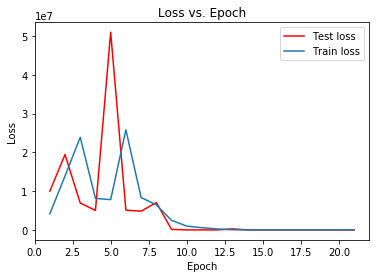

In [27]:
## Use patience of 3
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 3 # Stop after three steps with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]


## Now, define an NN model using batch normalization. 
## First define and compile a model with a batch normalization layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, input_shape = (9, ), activation = 'relu'))
nn.add(BatchNormalization(momentum = 0.99))
nn.add(layers.Dense(1))
## Define the optimizer and compile
optm = keras.optimizers.rmsprop(lr=1.0)
nn.compile(optimizer = optm, loss = 'mse', metrics = ['mae'])

## Now fit the model
nr.seed(345)
set_random_seed(4532)
history = nn.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

The loss decreases rapidly and then remains in a narrow range thereafter. It appears that convergence is quite rapid.

How does the accuracy evolve with the training episodes? Execute the code in the cell below to display the result.

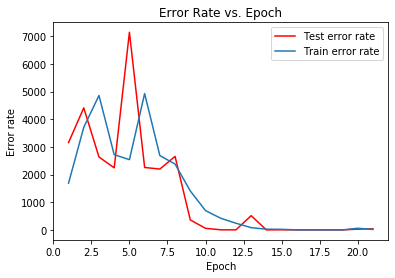

In [28]:
plot_accuracy(history)

This accuracy curve is rather unusual. It seems to reflect the simple regularization being used.

Finally, execute the code in the cell below to evaluate the predictions made with this model.

3.257593955382009


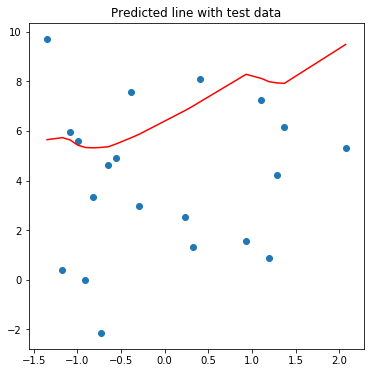

In [29]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

USING MULTIPLE REGULARIZATION METHODS

Exercise 2: In many cases more than one regularization method is applied. We have already applied early stopping with other regularization methods. In this exercise you will create a neural network work using four regularization methods at once:


1.   l2 regularization
2.   l1 regularization
3.   Dropout
4.   Early stopping
In the cell below create code for a neural network using the above regularization methods. Your code should include the following:


*   Set a numpy.random seed of 242244 and a set_random_seed for the TensorFlow backend of 4356.
*   Define a call back list with EarlyStopping with monitor set to val_loss and patience set to 4, and the ModelCheckpoint with monitor set to val_loss.
    A fully connected layer with 128 units and EeLU activation. Include l1 and l2 regularization using the l1_l2 function with the regularization parameter set to 50.0.
    A dropout layer with regularization parameter set to 0.5.
    Fit your model for 120 epochs, with batch size of 10, using the already defined callback list.

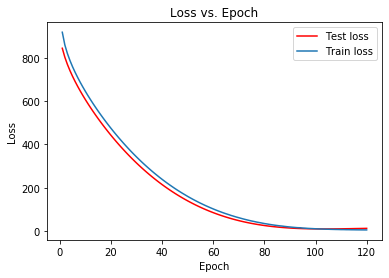

In [33]:
nr.seed(242244)
set_random_seed(4356)

#l2 regularization
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(50.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 10,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)

3.1923429470584566


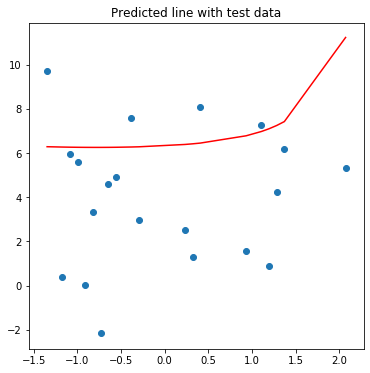

In [34]:
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 10,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

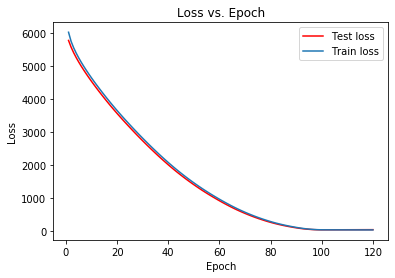

In [35]:
# l1 Regularization with a neural network
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l1(50.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 10,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)

2.9996401629169385


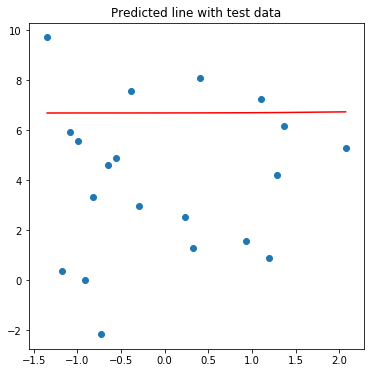

In [36]:
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 10,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

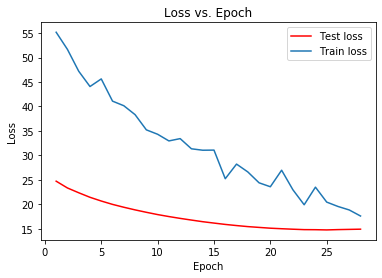

In [37]:
# DROPOUT REGULARIZATION
## First define and compile a model with a dropout layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(Dropout(rate = 0.5)) # Use 50% dropout on this model
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

## Now fit the model
nr.seed(24224)
set_random_seed(4356)
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 10,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

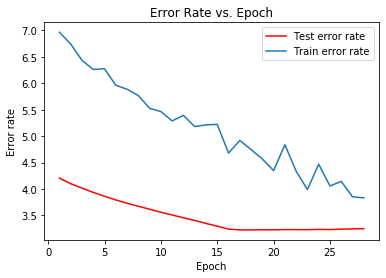

In [38]:
plot_accuracy(history)

3.257593955382009


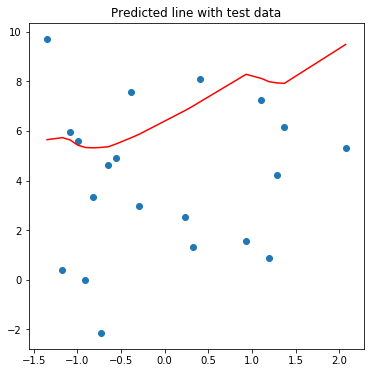

In [39]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

In [0]:
# EARLY STOPPING 
## First define and compile a model. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(1.0)))
nn.add(layers.Dense(1))

nn.compile(optimizer = 'RMSprop', loss = 'mse', metrics = ['mae'])

## Define the callback list
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 1 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now fit the model
nr.seed(24224)
set_random_seed(4356)
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 10,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

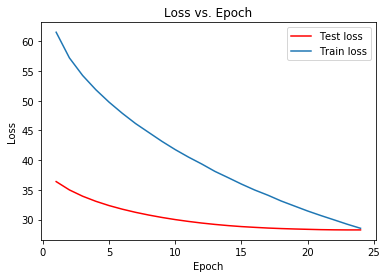

In [41]:
## Visualize the outcome
plot_loss(history)

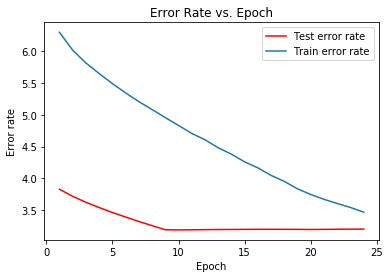

In [42]:
def plot_accuracy(history):
    train_acc = history.history['mean_absolute_error']
    test_acc = history.history['val_mean_absolute_error']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test error rate')
    plt.plot(x, train_acc, label = 'Train error rate')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error rate')
    plt.title('Error Rate vs. Epoch')  
    
plot_accuracy(history)  

4.537536446375417


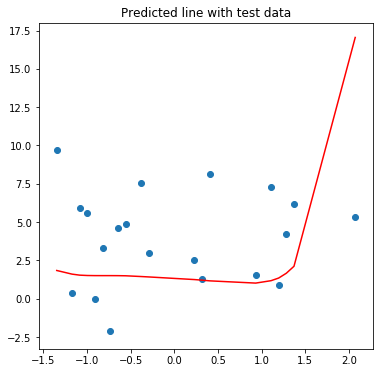

In [43]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))